here we are getting all bike parking locations using LTA datamall. there is a query max radius of 5km i think, so we are repeatedly querying across a 5km by 5km grid to capture the entire area of sg.

In [8]:
import requests
import pandas as pd
import numpy as np
from itertools import product

# Load environment variables
load_dotenv()
lta_access_key = os.getenv("LTA_ACCESS_KEY")

# Define the API endpoint and headers
url = "http://datamall2.mytransport.sg/ltaodataservice/BicycleParkingv2"
headers = {"AccountKey": lta_access_key}

# Define the bounding box for Singapore (these coordinates will need to be accurate)
# Assuming that these are the approximate bounding coordinates for Singapore
north = 1.4700
south = 1.2000
east = 104.1000
west = 103.6000

# Since the radius of coverage is 5km, we can use a step less than 10km to ensure full coverage
step = 0.05  # Approximately 5km

# Generate grid points
lats = np.arange(south, north, step)
longs = np.arange(west, east, step)
grid_points = product(lats, longs)

# This DataFrame will hold all the results
all_parkings_df = pd.DataFrame()

# Query the API for each grid point
for point in grid_points:
    params = {
        "Lat": point[0],
        "Long": point[1],
        "Dist": 5  # Distance in km
    }
    response = requests.get(url, headers=headers, params=params)

    # Check the response status
    if response.status_code == 200:
        # Parse the response JSON and convert to DataFrame
        data = response.json()['value']
        if data:  # Check if data is not empty
            parking_df = pd.DataFrame(data)
            # Append the results to the all_parkings_df DataFrame
            all_parkings_df = pd.concat([all_parkings_df, parking_df], ignore_index=True)
    else:
        print(f"Failed at {point}. Status code: {response.status_code}, Response content: {response.text}")

# Remove possible duplicates from the all_parkings_df DataFrame
all_parkings_df = all_parkings_df.drop_duplicates(subset=['Latitude', 'Longitude'])

# Save the unique bicycle parking locations to a CSV file
all_parkings_df.to_csv("../data/unique_bicycle_parking_data.csv", index=False)

print(f"Total unique bicycle parking locations: {len(all_parkings_df)}")


Total unique bicycle parking locations: 25043


Simple map visualisation of bike parking locations

In [11]:

import pandas as pd
import folium


# Initialize the map centered around Singapore
map_center = [all_parkings_df['Latitude'].mean(), all_parkings_df['Longitude'].mean()]
sg_map = folium.Map(location=map_center, zoom_start=12)

# Add points to the map
for idx, row in all_parkings_df.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']]).add_to(sg_map)

# Display the map
sg_map.save('../data/singapore_bicycle_parkings.html')

/Users/ethan/Library/Python/3.11/lib/python/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


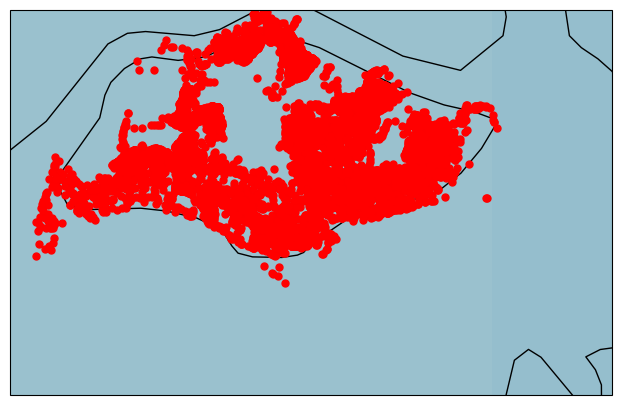

In [19]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([103.6, 104.1, 1.15, 1.47])

ax.stock_img()
ax.coastlines()

# Plot each point
for _, row in all_parkings_df.iterrows():
    plt.plot(row['Longitude'], row['Latitude'], markersize=5, marker='o', color='red', transform=ccrs.Geodetic())

plt.show()
